In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, mean_absolute_error
import shap

from utils.feature_extraction_utils import zip_dicts
from utils.model_training_utils import load_features, stratify_df, select_features, train_model, stratify_perm_df

c:\Users\Administrator\Documents\GitHub\mcsa-misalignment\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_folder = "./../data/"
features_folder = data_folder + "features/"
feature_subsets = ['low_res', 'high_res', 'combined']
selected_feature_subset = feature_subsets[2]

In [3]:
feat_dict = load_features(features_folder, selected_feature_subset)
feature_names_dict = {window_size:feat_df.drop(['misalignment', 'recording_nr', 'direction', 'speed', 'window_id'], axis=1).columns.values for window_size, feat_df in feat_dict.items()}

100%|██████████| 7/7 [00:01<00:00,  6.79it/s]


In [4]:
for window_size, feature_name_list in feature_names_dict.items():
    print(f"Window size: {window_size}")
    print(f"Number of features: {len(feature_name_list)}")
    print(f"Features: {feature_name_list}")
    print()

Window size: 12800
Number of features: 321
Features: ['high_res__app_entropy__w=12800' 'high_res__hjorth_complexity__w=12800'
 'high_res__hjorth_mobility__w=12800' 'high_res__katz_fd__w=12800'
 "high_res__matrix_profile_{'threshold': 0.9, 'feature': '25'}__w=12800"
 "high_res__matrix_profile_{'threshold': 0.9, 'feature': '75'}__w=12800"
 "high_res__matrix_profile_{'threshold': 0.9, 'feature': 'max'}__w=12800"
 "high_res__matrix_profile_{'threshold': 0.9, 'feature': 'mean'}__w=12800"
 "high_res__matrix_profile_{'threshold': 0.9, 'feature': 'median'}__w=12800"
 "high_res__matrix_profile_{'threshold': 0.9, 'feature': 'min'}__w=12800"
 "high_res__matrix_profile_{'threshold': 0.95, 'feature': '25'}__w=12800"
 "high_res__matrix_profile_{'threshold': 0.95, 'feature': '75'}__w=12800"
 "high_res__matrix_profile_{'threshold': 0.95, 'feature': 'max'}__w=12800"
 "high_res__matrix_profile_{'threshold': 0.95, 'feature': 'mean'}__w=12800"
 "high_res__matrix_profile_{'threshold': 0.95, 'feature': 'med

In [5]:
# Write own stratified function based on multible labels
stratify_dict = {window_size:stratify_df(feat_df, ['misalignment', 'direction', 'speed']) for window_size, feat_df in feat_dict.items()}

In [ ]:
sel_feat_dict = {}
for window_size, feature_names, split_dict in zip_dicts(feature_names_dict, stratify_dict):
    print("Window size:", window_size)
    window_key = f"window_size={window_size}"
    selected_feats, scores = select_features(feature_names, split_dict)
    sel_feat_dict[window_key] = {"selected_features": selected_feats, "scores": scores}

# Check if selected folder exists
selected_folder = features_folder + 'selected/'
if not os.path.exists(selected_folder):
    # Create folder
    os.makedirs(selected_folder)
# Pickle the selected features and scores
with open(f"{selected_folder}selected_features_{selected_feature_subset}.pkl", "wb") as f:
    pickle.dump(sel_feat_dict, f)

In [6]:
# Read the selected features from the pickle files
sel_feat_dict = {}
selected_folder = features_folder + 'selected/'
with open(f"{selected_folder}selected_features_{selected_feature_subset}.pkl", "rb") as f:
    sel_feat_dict = pickle.load(f)
# Rename keys in dictionary
sel_feat_names_dict = {int(key.split('=')[1]):value['selected_features'] for key, value in sel_feat_dict.items()}
sel_feat_score_dict = {int(key.split('=')[1]):value['scores'] for key, value in sel_feat_dict.items()}

In [7]:
# Print number of features per window size
for window_size, selected_features in sel_feat_names_dict.items():
    print(f"Window size: {window_size}")
    print(f"Number of features: {len(selected_features)}")
    # Print number containing "low_res" and "high_res"
    low_res = sum([1 for feature in selected_features if "low_res" in feature])
    high_res = sum([1 for feature in selected_features if "high_res" in feature])
    print(f"Number of low_res features: {low_res}")
    print(f"Number of high_res features: {high_res}")
    print(f"Features: {selected_features}")
    print()

Window size: 400
Number of features: 13
Number of low_res features: 3
Number of high_res features: 10
Features: ["low_res__spkt_welch_density_{'coeff': 1}__w=400", "high_res__spkt_welch_density_{'coeff': 1}__w=400", "high_res__spkt_welch_density_{'coeff': 7}__w=400", "high_res__spkt_welch_density_{'coeff': 11}__w=400", "high_res__spkt_welch_density_{'coeff': 3}__w=400", "high_res__spkt_welch_density_{'coeff': 9}__w=400", "high_res__spkt_welch_density_{'coeff': 13}__w=400", "high_res__spkt_welch_density_{'coeff': 5}__w=400", "high_res__spkt_welch_density_{'coeff': 20}__w=400", "high_res__spkt_welch_density_{'coeff': 19}__w=400", "low_res__spkt_welch_density_{'coeff': 3}__w=400", "high_res__spkt_welch_density_{'coeff': 15}__w=400", "low_res__spkt_welch_density_{'coeff': 5}__w=400"]

Window size: 6400
Number of features: 10
Number of low_res features: 3
Number of high_res features: 4
Features: ['high_res__std_peak_diff', "low_res__matrix_profile_{'threshold': 0.9, 'feature': 'max'}__w=640

In [8]:
pipe_dict = {window_size:train_model(window_size, split_dict, sorted(sel_feat_names)) for window_size, split_dict, sel_feat_names in zip_dicts(stratify_dict, sel_feat_names_dict)}

Window size:  6400


100%|██████████| 5/5 [00:44<00:00,  8.88s/it]


MAE over train folds: 0.01231363797456303 +/- 0.0005484149967583909
MAE over test folds: 0.04080507285421701 +/- 0.004005711440221064

Window size:  12800


100%|██████████| 5/5 [00:33<00:00,  6.73s/it]


MAE over train folds: 0.008842706579272972 +/- 0.0007421776228194273
MAE over test folds: 0.04169981731797081 +/- 0.007286607956382186

Window size:  1600


100%|██████████| 5/5 [00:40<00:00,  8.05s/it]


MAE over train folds: 0.038612410623129416 +/- 0.0014856602963553482
MAE over test folds: 0.07548673788481605 +/- 0.0038677848734437123

Window size:  3200


100%|██████████| 5/5 [00:45<00:00,  9.07s/it]


MAE over train folds: 0.016569269067385307 +/- 0.0007106136576838163
MAE over test folds: 0.048812161023033776 +/- 0.003917149157307701

Window size:  800


100%|██████████| 5/5 [01:05<00:00, 13.17s/it]


MAE over train folds: 0.06690489424043901 +/- 0.0008290356836618611
MAE over test folds: 0.11619217168258342 +/- 0.0008497823128202837

Window size:  400


100%|██████████| 5/5 [01:19<00:00, 15.98s/it]

MAE over train folds: 0.12670875168308182 +/- 0.000870929117627853
MAE over test folds: 0.1784069472513287 +/- 0.0027808551793866987



In [ ]:
# Save models
# Check if models folder exists
models_folder = data_folder + 'models/'
if not os.path.exists(models_folder):
    os.makedirs(models_folder)
for window_size, pipe_list in pipe_dict.items():
    with open(f"{models_folder}{selected_feature_subset}_{window_size}_model.pkl", "wb") as f:
        pickle.dump(pipe_list, f)

In [ ]:
# Load models
pipe_dict = {}
# list all files in the models folder
models_folder = data_folder + 'models/'
files = os.listdir(models_folder)
# loop through the files and load the models
for file in files:
    window_size = int(file.split("_")[1])
    with open(models_folder + file, "rb") as f:
        pipe_dict[window_size] = pickle.load(f)

Window size:  6400


100%|██████████| 5/5 [00:00<00:00, 31.31it/s]

MAE over train folds: 0.01231363797456303 +/- 0.0005484149967583909
MAE over test folds: 0.04080507285421701 +/- 0.004005711440221064


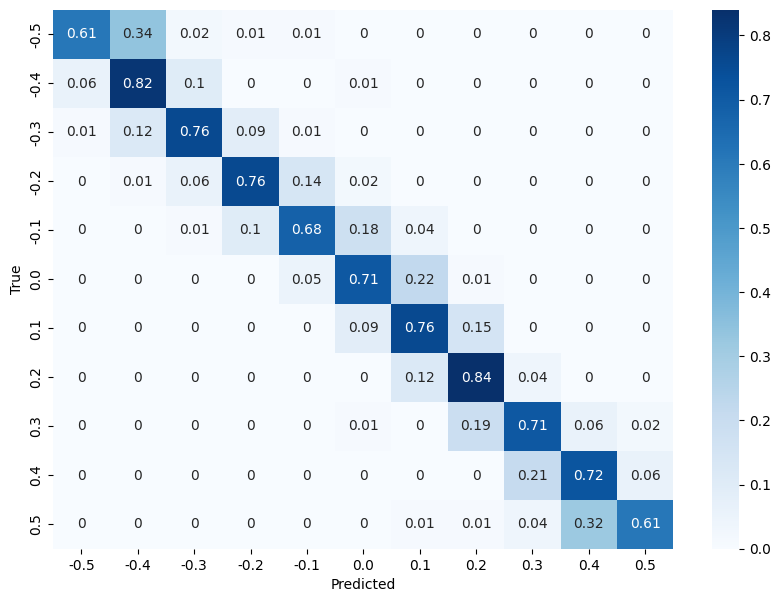

Window size:  12800


100%|██████████| 5/5 [00:00<00:00, 33.60it/s]

MAE over train folds: 0.008842706579272972 +/- 0.0007421776228194273
MAE over test folds: 0.04169981731797081 +/- 0.007286607956382186


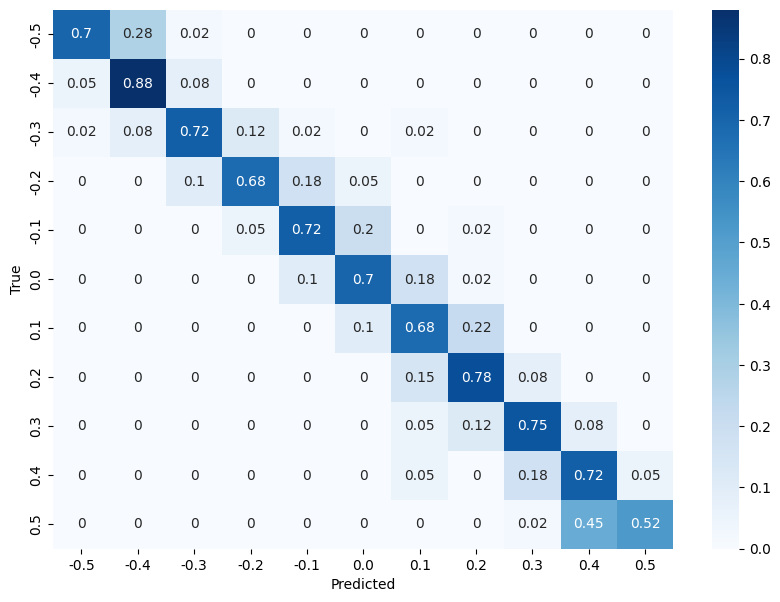

Window size:  800


100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


MAE over train folds: 0.06690489424043901 +/- 0.0008290356836618611
MAE over test folds: 0.11619217168258342 +/- 0.0008497823128202837


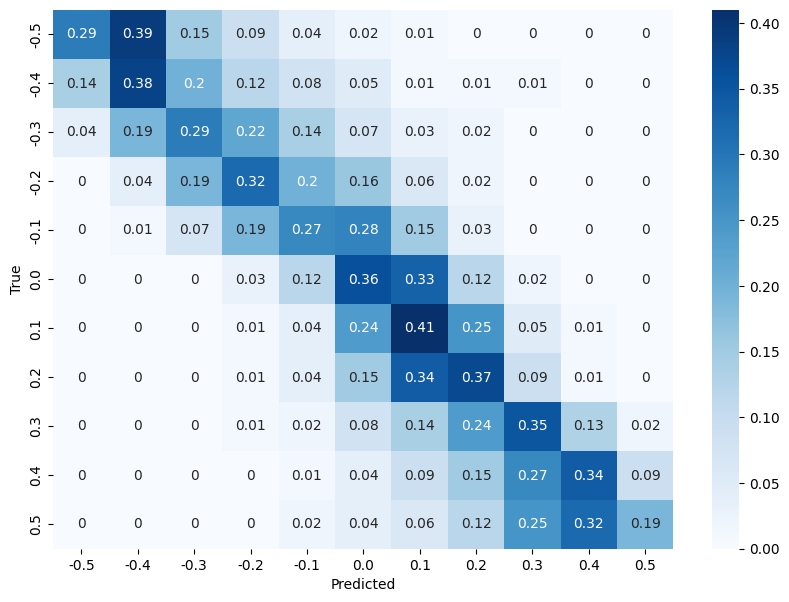

Window size:  1600


100%|██████████| 5/5 [00:00<00:00, 16.27it/s]


MAE over train folds: 0.038612410623129416 +/- 0.0014856602963553482
MAE over test folds: 0.07548673788481605 +/- 0.0038677848734437123


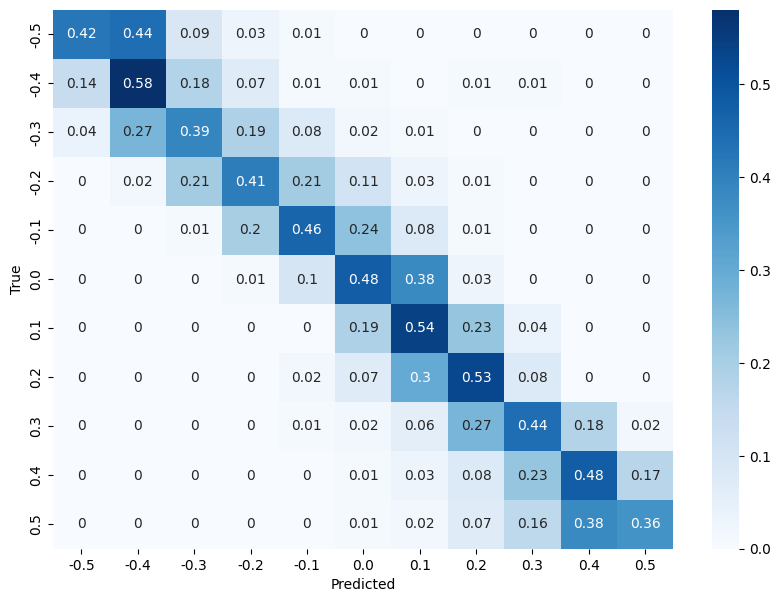

Window size:  3200


100%|██████████| 5/5 [00:00<00:00, 30.15it/s]

MAE over train folds: 0.016569269067385307 +/- 0.0007106136576838163
MAE over test folds: 0.048812161023033776 +/- 0.003917149157307701


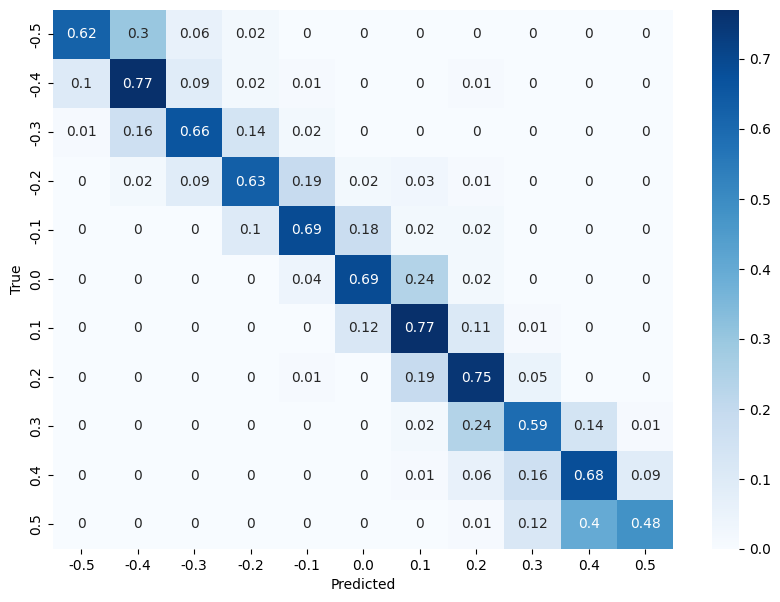

Window size:  400


100%|██████████| 5/5 [00:00<00:00, 17.49it/s]


MAE over train folds: 0.12670875168308182 +/- 0.000870929117627853
MAE over test folds: 0.1784069472513287 +/- 0.0027808551793866987


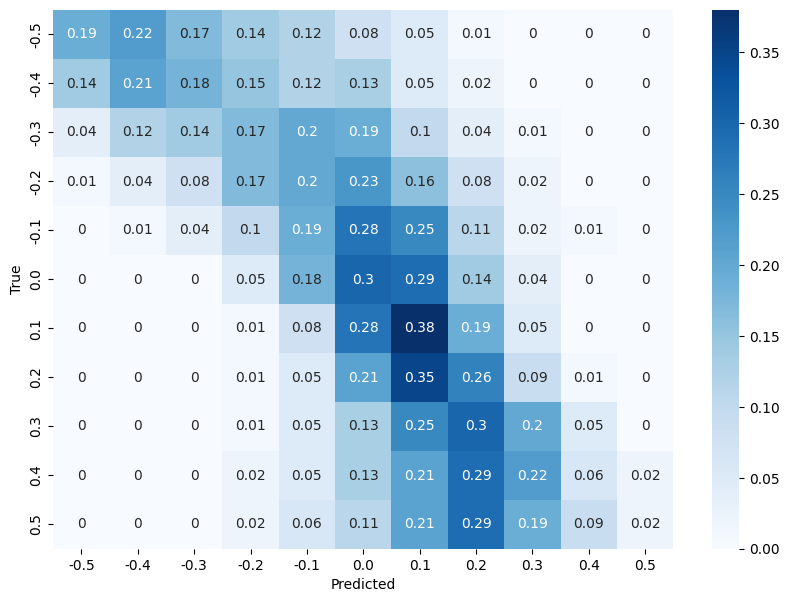

In [9]:
for window_size, split_dict, sel_feat_names, pipe_list in zip_dicts(stratify_dict, sel_feat_names_dict, pipe_dict):
    print("Window size: ", window_size)
    train_mae_list = []
    test_mae_list = []

    train_list = []
    train_preds_list = []
    test_list = []
    test_preds_list = []
    for fold_nr, set_dict in tqdm(split_dict.items()):
        x_train = set_dict['train'].drop(['misalignment', 'recording_nr', 'direction', 'speed', 'window_id'], axis=1)[sel_feat_names]
        x_test = set_dict['test'].drop(['misalignment', 'recording_nr', 'direction', 'speed', 'window_id'], axis=1)[sel_feat_names]
        y_train = set_dict['train']['misalignment']
        y_test = set_dict['test']['misalignment']

        train_preds = pipe_list[fold_nr-1].predict(x_train)
        train_mae = mean_absolute_error(y_train, train_preds)
        train_mae_list.append(train_mae)
        train_list.append(y_train)
        train_preds_list.append(train_preds)

        test_preds = pipe_list[fold_nr-1].predict(x_test)
        test_mae = mean_absolute_error(y_test, test_preds)
        test_mae_list.append(test_mae)
        test_list.append(y_test)
        test_preds_list.append(test_preds)

        # print("MAE over train folds:", train_mae) 
        # print("MAE over test folds:", test_mae)
        # print()

    print("MAE over train folds:", np.mean(train_mae_list), "+/-", np.std(train_mae_list))
    print("MAE over test folds:", np.mean(test_mae_list), "+/-", np.std(test_mae_list))

    # Construct confusion matrix using seaborn
    # Create a confusion matrix
    test_list = np.concatenate(test_list)
    test_preds_list = np.concatenate(test_preds_list)

    test_list = np.round((test_list * 10) + 6)
    test_preds_list = np.round((test_preds_list * 10) + 6)

    # All predictions that exceed the limits are set to the limits
    test_preds_list[test_preds_list > 11] = 11
    test_preds_list[test_preds_list < 1] = 1

    cm = confusion_matrix(test_list, test_preds_list)
    # Normalize confusion matrix and round to 2 decimal places
    cm = np.round(cm / cm.sum(axis=1)[:, np.newaxis], 2)

    # Create a dataframe from the confusion matrix
    df_cm = pd.DataFrame(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap='Blues', xticklabels=np.array(list(range(-5, 6, 1)))/10, yticklabels=np.array(list(range(-5, 6, 1)))/10)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Window size:  6400


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


MAE over train folds: 0.01231363797456303 +/- 0.0005484149967583909
MAE over test folds: 0.04080507285421701 +/- 0.004005711440221064


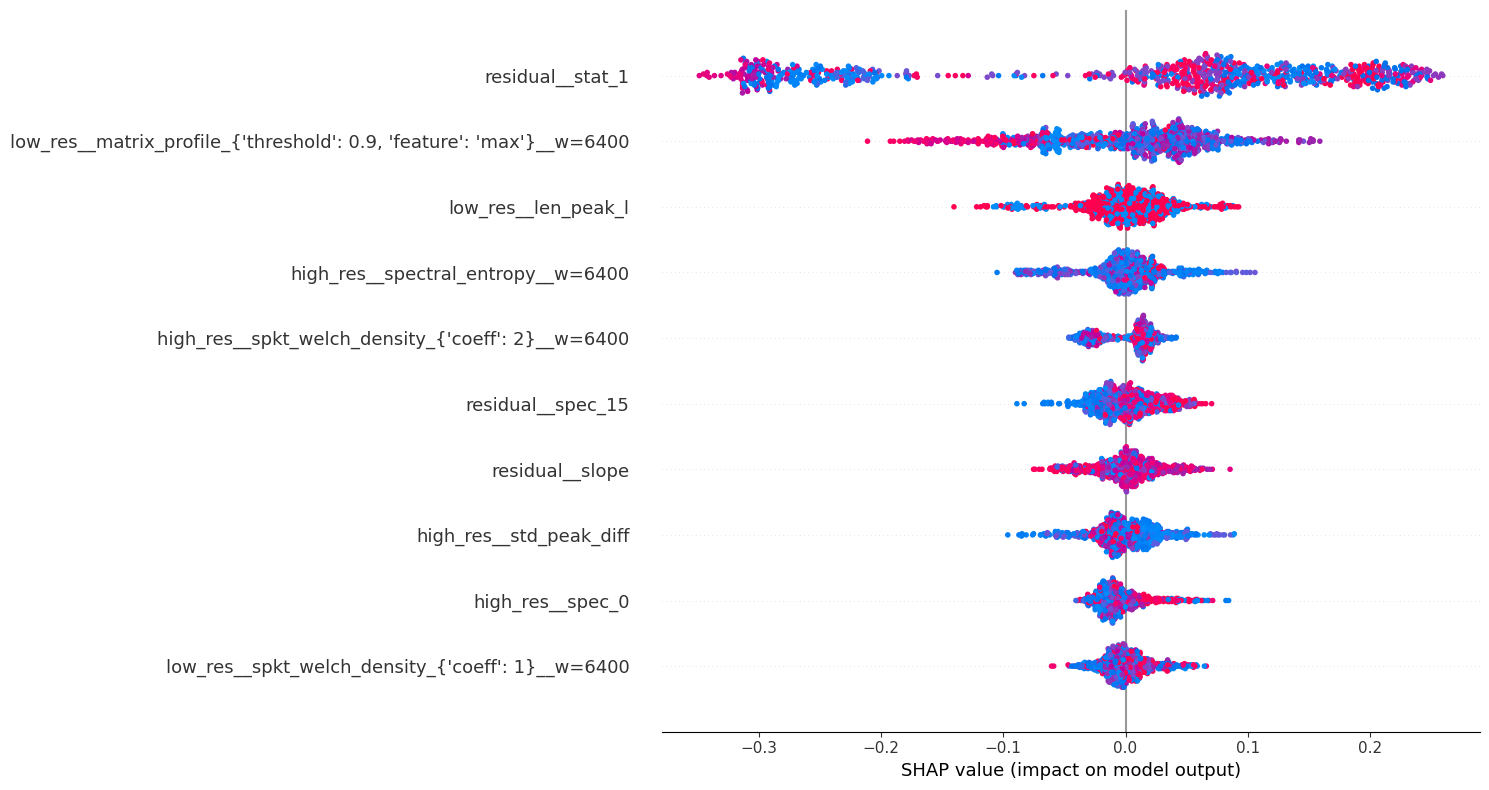

Window size:  12800


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


MAE over train folds: 0.008842706579272972 +/- 0.0007421776228194273
MAE over test folds: 0.04169981731797081 +/- 0.007286607956382186


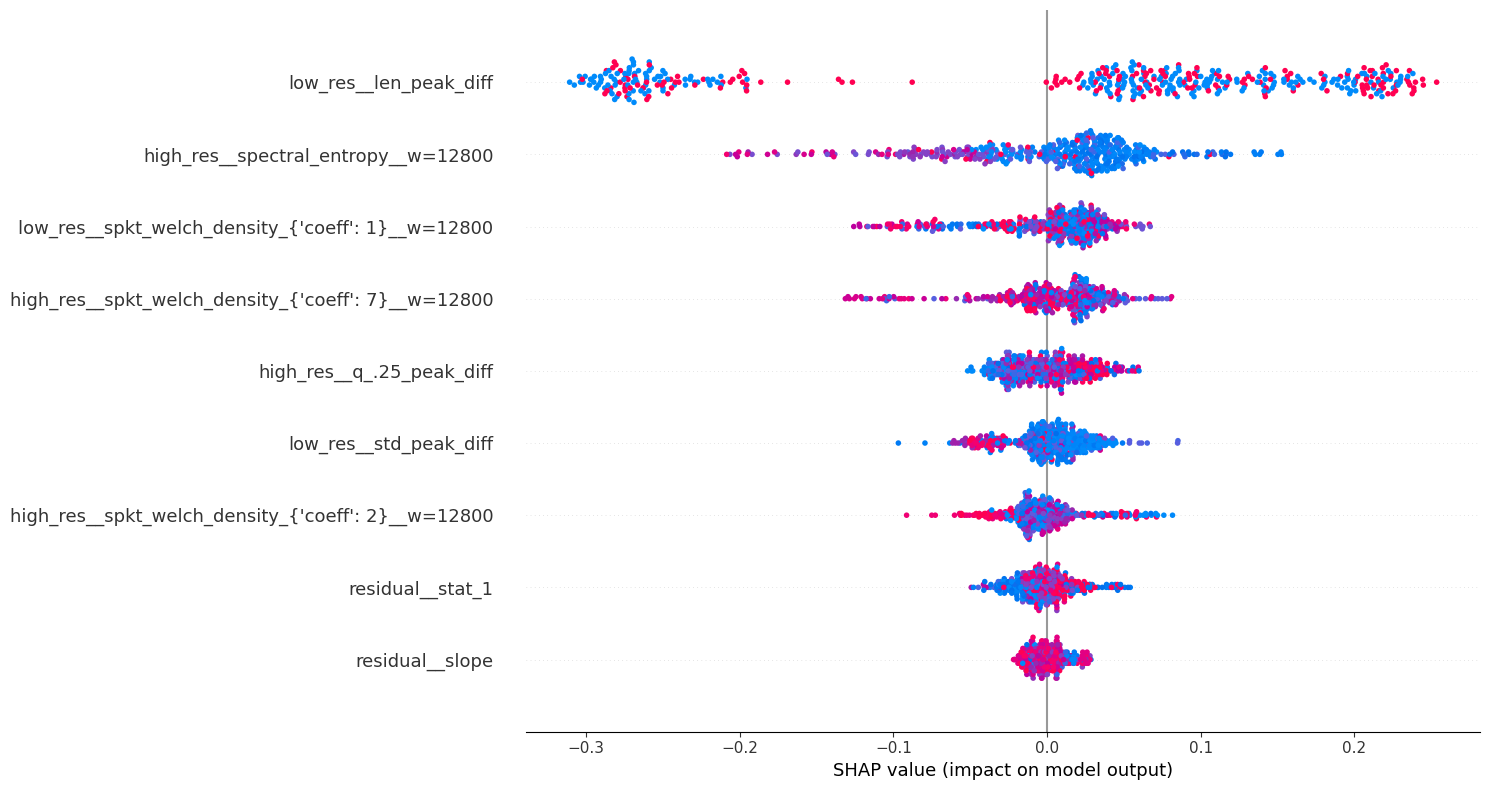

Window size:  800


100%|██████████| 5/5 [00:20<00:00,  4.17s/it]


MAE over train folds: 0.06690489424043901 +/- 0.0008290356836618611
MAE over test folds: 0.11619217168258342 +/- 0.0008497823128202837


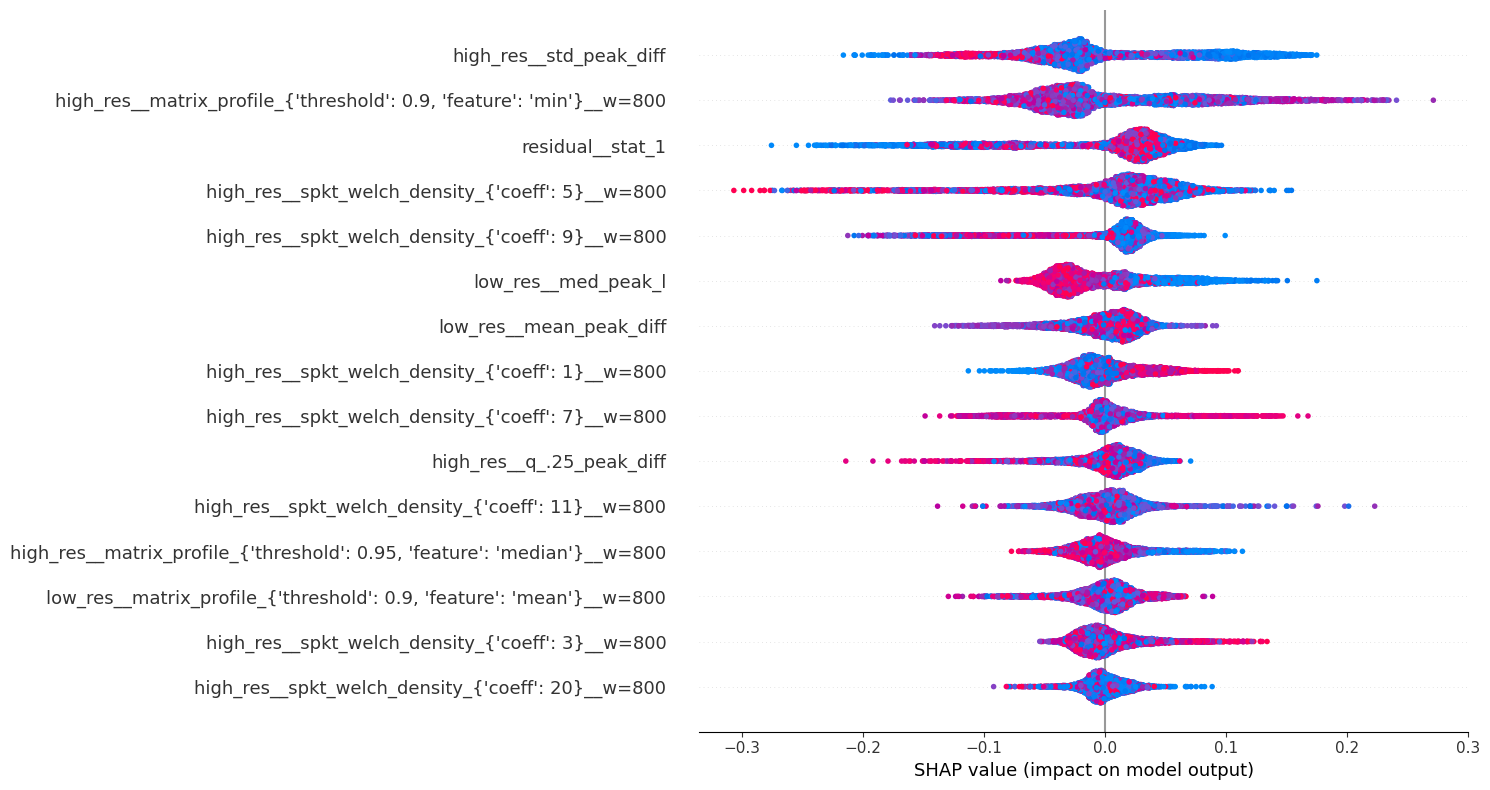

Window size:  1600


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


MAE over train folds: 0.038612410623129416 +/- 0.0014856602963553482
MAE over test folds: 0.07548673788481605 +/- 0.0038677848734437123


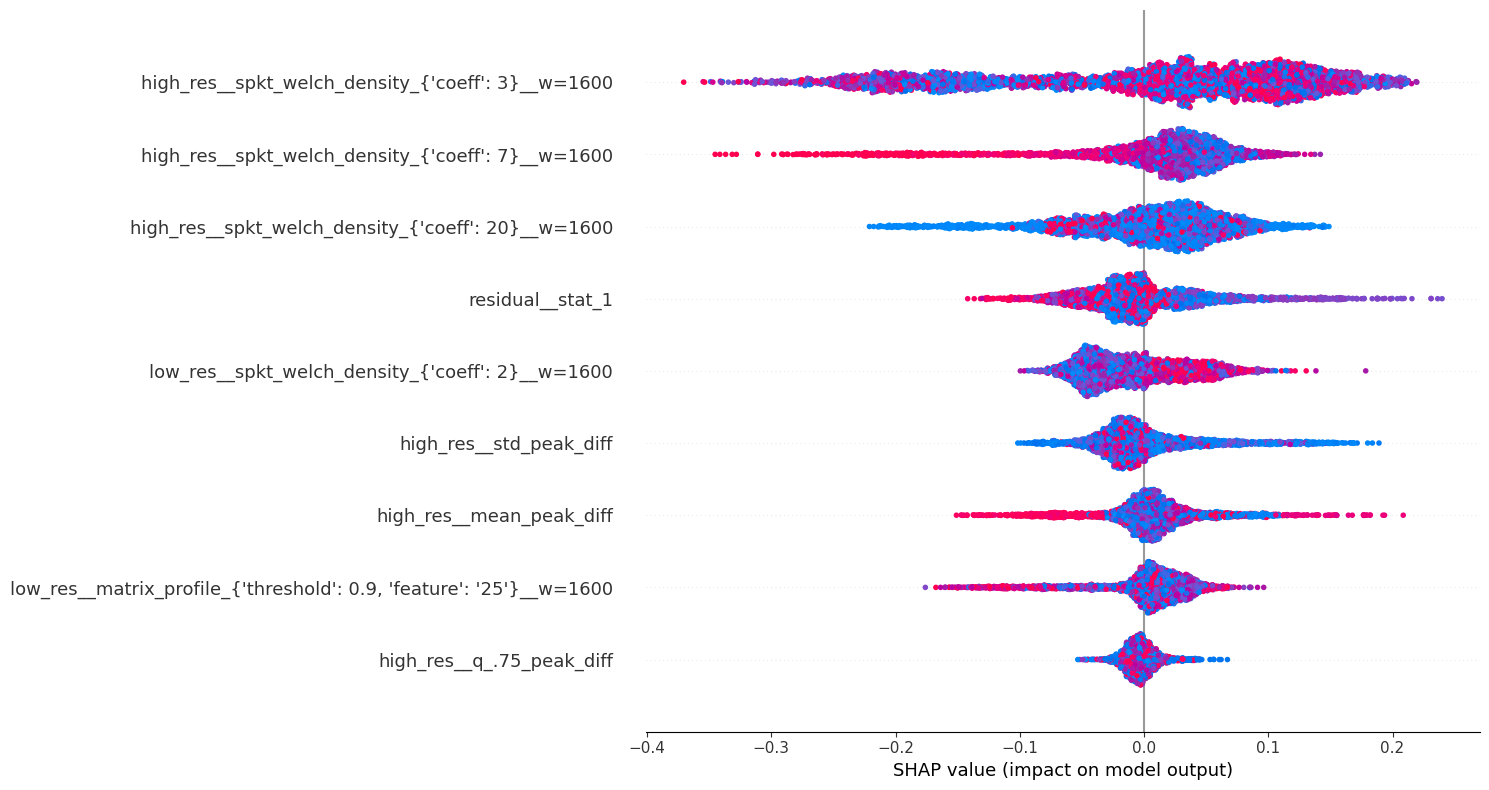

Window size:  3200


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


MAE over train folds: 0.016569269067385307 +/- 0.0007106136576838163
MAE over test folds: 0.048812161023033776 +/- 0.003917149157307701


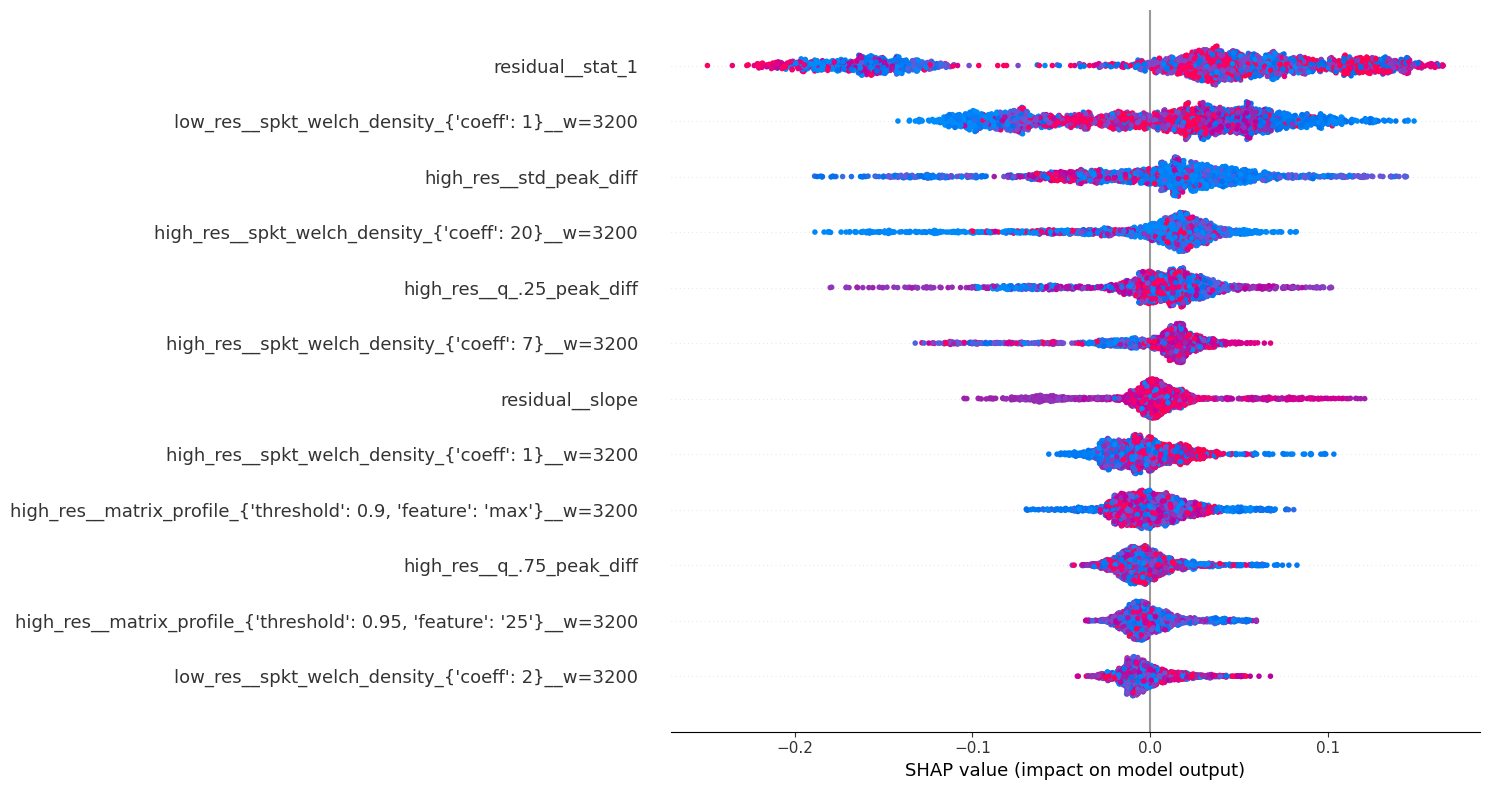

Window size:  400


100%|██████████| 5/5 [00:24<00:00,  4.99s/it]


MAE over train folds: 0.12670875168308182 +/- 0.000870929117627853
MAE over test folds: 0.1784069472513287 +/- 0.0027808551793866987


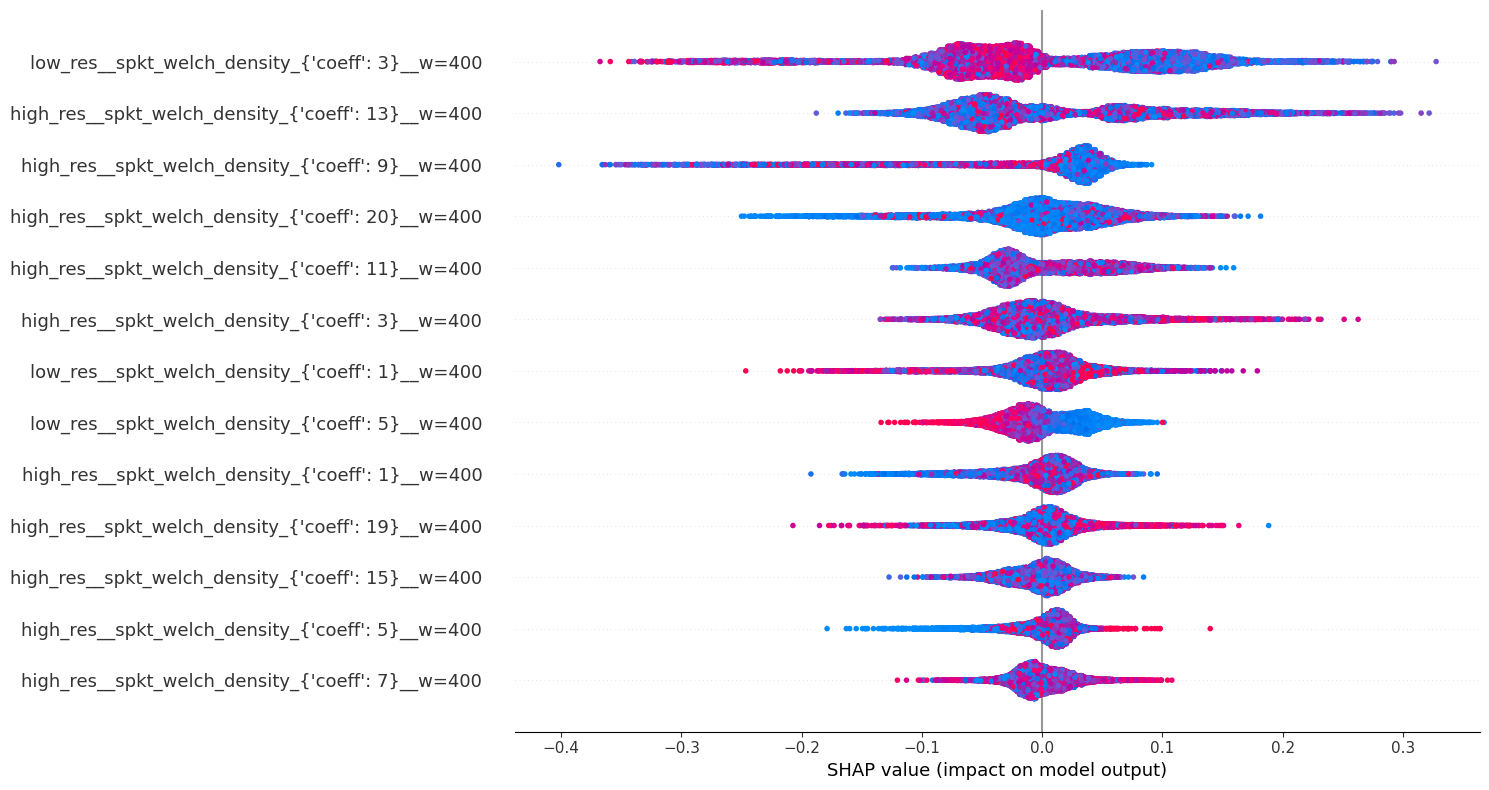

In [10]:
for window_size, split_dict, sel_feat_names, pipe_list in zip_dicts(stratify_dict, sel_feat_names_dict, pipe_dict):
    print("Window size: ", window_size)
    shap_list = []
    test_list = []
    train_mae_list = []
    test_mae_list = []
    for fold_nr, set_dict in tqdm(split_dict.items()):
        x_train = set_dict['train'].drop(['misalignment', 'recording_nr', 'direction', 'speed', 'window_id'], axis=1)[sel_feat_names]
        x_test = set_dict['test'].drop(['misalignment', 'recording_nr', 'direction', 'speed', 'window_id'], axis=1)[sel_feat_names]
        y_train = set_dict['train']['misalignment']
        y_test = set_dict['test']['misalignment']

        train_preds = pipe_list[fold_nr-1].predict(x_train)
        train_mae = mean_absolute_error(y_train, train_preds)
        train_mae_list.append(train_mae)

        test_preds = pipe_list[fold_nr-1].predict(x_test)
        test_mae = mean_absolute_error(y_test, test_preds)
        test_mae_list.append(test_mae)

        explainer = shap.TreeExplainer(pipe_list[fold_nr-1])
        shap_list.append(explainer.shap_values(x_test))
        test_list.append(x_test)
    
    print("MAE over train folds:", np.mean(train_mae_list), "+/-", np.std(train_mae_list))
    print("MAE over test folds:", np.mean(test_mae_list), "+/-", np.std(test_mae_list))
    
    shap_values = np.concatenate(shap_list)
    test_values = np.concatenate(test_list)
    plt.figure()
    shap.summary_plot(shap_values, test_values, feature_names=sel_feat_names, max_display=20, plot_size=(15, 8), plot_type='dot', show=False, color_bar=False)
    # Check if shap folder exists
    if not os.path.exists(data_folder + "shap/"):
        os.makedirs(data_folder + "shap/")
    # Save figure
    plt.savefig(data_folder + "shap/" + str(window_size) + "_shap.png", bbox_inches='tight')
    plt.show()    

In [11]:
stratify_perm_dict = {window_size:stratify_perm_df(feat_df, ['misalignment', 'direction', 'speed'], ['direction', 'speed']) for window_size, feat_df in feat_dict.items()}

In [12]:
for window_size, split_dict, sel_feat_names, pipe_list in zip_dicts(stratify_perm_dict, sel_feat_names_dict, pipe_dict):
    print("Window size: ", window_size)
    for config, fold_dict in split_dict.items():
        print("Config: ", config)
        train_mae_list = []
        test_mae_list = []
        for fold_nr, set_dict in fold_dict.items():
            x_train = set_dict['train'].drop(['misalignment', 'recording_nr', 'direction', 'speed', 'window_id'], axis=1)[sel_feat_names]
            x_test = set_dict['test'].drop(['misalignment', 'recording_nr', 'direction', 'speed', 'window_id'], axis=1)[sel_feat_names]
            y_train = set_dict['train']['misalignment']
            y_test = set_dict['test']['misalignment']

            train_preds = pipe_list[fold_nr-1].predict(x_train)
            train_mae = mean_absolute_error(y_train, train_preds)
            train_mae_list.append(train_mae)

            test_preds = pipe_list[fold_nr-1].predict(x_test)
            test_mae = mean_absolute_error(y_test, test_preds)
            test_mae_list.append(test_mae)

            # print("MAE over train folds:", train_mae) 
            # print("MAE over test folds:", test_mae)
            # print()

        print("MAE over train folds:", np.mean(train_mae_list), "+/-", np.std(train_mae_list))
        print("MAE over test folds:", np.mean(test_mae_list), "+/-", np.std(test_mae_list))
        print()

Window size:  6400
Config:  ('H', 425)
MAE over train folds: 0.014926568641534355 +/- 0.0006503803118353182
MAE over test folds: 0.04948064298390413 +/- 0.011334784130345906

Config:  ('H', 750)
MAE over train folds: 0.011215172688263336 +/- 0.0005341906069777692
MAE over test folds: 0.03411212054962185 +/- 0.004256128273914214

Config:  ('V', 425)
MAE over train folds: 0.010557735458714638 +/- 0.0002622314817263687
MAE over test folds: 0.03461990876374442 +/- 0.006830682367302927

Config:  ('V', 750)
MAE over train folds: 0.012555075109739789 +/- 0.0009815067594268875
MAE over test folds: 0.04500761911959763 +/- 0.0033483961470585724

Window size:  12800
Config:  ('H', 425)
MAE over train folds: 0.011565564096371283 +/- 0.001114315034551202
MAE over test folds: 0.05213538058818971 +/- 0.010748730999907752

Config:  ('H', 750)
MAE over train folds: 0.008139972485248819 +/- 0.0005690248880245627
MAE over test folds: 0.04153316985385726 +/- 0.006053817091943294

Config:  ('V', 425)
MAE o